<a href="https://colab.research.google.com/github/skywalker0803r/c620/blob/main/notebook/experiment/wraps_the_post_processing_together_in_the_neural_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# load data

In [1]:
import pandas as pd
import joblib
import numpy as np

df = pd.read_csv('/content/drive/MyDrive/台塑輕油案子/data/c620/cleaned/c620_train.csv',index_col=0)
c = joblib.load('/content/drive/MyDrive/台塑輕油案子/data/c620/col_names/c620_col_names.pkl')
x_col = c['x41']+c['case']+c['density']+c['yRefluxRate']+c['yHeatDuty']+c['yControl']
y_col = c['vent_gas_x']+c['distillate_x']+c['sidedraw_x']+c['bottoms_x']
df.head(1)

,Combined Feed to Tatoray Stripper C620_Flow Rate_Volume Flow Rate_m3/hr,Combined Feed to Tatoray Stripper C620_Flow Rate_Mass Flow Rate_ton/hr,Combined Feed to Tatoray Stripper C620_Detailed Composition_Hydrogen_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Methane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Ethane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Propane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Butane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Pentane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Hexane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Benzene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Cyclohexane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Heptane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Water_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Methylcyclohexane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Toluene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Octane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Propylcyclopentane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Ethylcyclohexane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Ethylbenzene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_p-Xylene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_m-Xylene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_o-Xylene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Nonane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_i-Propylbenzene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Propylcyclohexane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Propylbenzene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_1-Methyl-3-ethylbenzene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_1-Methyl-4-ethylbenzene_wt%,"Combined Feed to Tatoray Stripper C620_Detailed Composition_1,3,5-Trimethylbenzene_wt%",Combined Feed to Tatoray Stripper C620_Detailed Composition_1-Methyl-2-ethylbenzene_wt%,"Combined Feed to Tatoray Stripper C620_Detailed Composition_1,2,4-Trimethylbenzene_wt%",Combined Feed to Tatoray Stripper C620_Detailed Composition_tert-Butylcyclohexane_wt%,"Combined Feed to Tatoray Stripper C620_Detailed Composition_1,2,3-Trimethylbenzene_wt%",Combined Feed to Tatoray Stripper C620_Detailed Composition_Indane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_1-Methyl-4-n-propylbenzene_wt%,"Combined Feed to Tatoray Stripper C620_Detailed Composition_1,2-Diethylbenzene_wt%",Combined Feed to Tatoray Stripper C620_Detailed Composition_5-Ethyl-m-xylene_wt%,"Combined Feed to Tatoray Stripper C620_Detailed Composition_1,4-Diethylbenzene_wt%","Combined Feed to Tatoray Stripper C620_Detailed Composition_1,2,3,5-Tetramethylbenzene_wt%",Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Pentylbenzene_wt%,...,Tatoray Stripper C620 Split Factors Calculation_Split Factor for Individual Component to Tatoray Stripper C620 Bottoms_n-Hexane_Fraction,Tatoray Stripper C620 Split Factors Calculation_Split Factor for Individual Component to Tatoray Stripper C620 Bottoms_Benzene_Fraction,Tatoray Stripper C620 Split Factors Calculation_Split Factor for Individual Component to Tatoray Stripper C620 Bottoms_Cyclohexane_Fraction,Tatoray Stripper C620 Split Factors Calculation_Split Factor for Individual Component to Tatoray Stripper C620 Bottoms_n-Heptane_Fraction,Tatoray Stripper C620 Split Factors Calculation_Split Factor for Individual Component to Tatoray Stripper C620 Bottoms_Water_Fraction,Tatoray Stripper C620 Split Factors Calculation_Split Factor for Individual Component to Tatoray Stripper C620 Bottoms_Methylcyclohexane_Fraction,Tatoray Stri

# preprocess data

In [2]:
from sklearn.utils import shuffle
from torch.utils.data import TensorDataset,DataLoader
from sklearn.preprocessing import MinMaxScaler
import torch

df = shuffle(df)
p1 = int(len(df)*0.8)
p2 = int(len(df)*0.9)

X_train = torch.FloatTensor(df[x_col].values[:p1])
Y_train = torch.FloatTensor(df[y_col].values[:p1])

X_vaild = torch.FloatTensor(df[x_col].values[p1:p2])
Y_vaild = torch.FloatTensor(df[y_col].values[p1:p2])

X_test = torch.FloatTensor(df[x_col].values[p2:])
Y_test = torch.FloatTensor(df[y_col].values[p2:])

trainset = TensorDataset(X_train,Y_train)
train_iter = DataLoader(trainset,batch_size=64)

vaildset = TensorDataset(X_vaild,Y_vaild)
vaild_iter = DataLoader(vaildset,batch_size=64)

testset = TensorDataset(X_test,Y_test)
test_iter = DataLoader(testset,batch_size=64)

# def model,loss,optimizer

In [3]:
import torch
from torch import nn
import torch.nn.functional as F

def mlp(sizes, activation, output_activation=nn.Identity):
  layers = []
  for j in range(len(sizes)-1):
    act = activation if j < len(sizes)-2 else output_activation
    layers += [nn.Linear(sizes[j], sizes[j+1]), act()]
  return nn.Sequential(*layers)

class Model(nn.Module):
  def __init__(self,in_dim,out_dim):
    super(Model, self).__init__()
    self.mlp = mlp([in_dim,256,256,out_dim],nn.ReLU,nn.Sigmoid)

  def forward(self,x):
    x41 = x[:,:41]
    sp = self.mlp(x).clone()
    for idx in range(41):
      sp[:,[idx,idx+41,idx+41*2,idx+41*3]] = self.normalize(sp[:,[idx,idx+41,idx+41*2,idx+41*3]])
    s1,s2,s3,s4 = sp[:,:41],sp[:,41:41*2],sp[:,41*2:41*3],sp[:,41*3:41*4]
    w1,w2,w3,w4 = self.sp2wt(x41,s1),self.sp2wt(x41,s2),self.sp2wt(x41,s3),self.sp2wt(x41,s4)
    return torch.cat((w1,w2,w3,w4),dim=-1)

  @staticmethod
  def normalize(x):
    return x / x.sum(dim=1).reshape(-1,1)
  
  @staticmethod
  def sp2wt(x,s):
    a = 100*x*s
    b = torch.diag(x@s.T).reshape(-1,1)
    b = torch.clip(b,1e-8,float('inf'))
    return a/b

model = Model(len(x_col),len(y_col))
optimizer = torch.optim.Adam(model.parameters())
loss_fn = nn.SmoothL1Loss()

# train model

In [4]:
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
from copy import deepcopy

# train step
def train_step(model):
  model.train()
  total_loss = 0
  for t,(x,y) in enumerate(train_iter):
    y_hat = model(x)
    loss = loss_fn(y_hat,y)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    total_loss += loss.item()
  return total_loss/(t+1)

# valid step
def valid_step(model):
  model.eval()
  total_loss = 0
  for t,(x,y) in enumerate(vaild_iter):
    y_hat = model(x)
    loss = loss_fn(y_hat,y)
    total_loss += loss.item()
  return total_loss/(t+1)

def train(model,max_epochs): 
  history = {
      'train_loss':[],
      'valid_loss':[]
      }
  current_loss = np.inf
  best_model = None
  for i in tqdm(range(max_epochs)):
      history['train_loss'].append(train_step(model))
      history['valid_loss'].append(valid_step(model))
      if i % 10 == 0:
        print("epoch:{} train_loss:{:.4f} valid_loss:{:.4f}".format(i,history['train_loss'][-1],history['valid_loss'][-1]))
      if history['valid_loss'][-1] <= current_loss:
        best_model = deepcopy(model.eval())
        current_loss = history['valid_loss'][-1]
  model = deepcopy(best_model.eval())
  plt.plot(history['train_loss'],label='train_loss')
  plt.plot(history['valid_loss'],label='valid_loss')
  plt.legend()
  plt.show()
  return model

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


epoch:0 train_loss:1.3552 valid_loss:1.2707
epoch:10 train_loss:0.0046 valid_loss:0.0036
epoch:20 train_loss:0.0031 valid_loss:0.0023
epoch:30 train_loss:0.0017 valid_loss:0.0015
epoch:40 train_loss:0.0013 valid_loss:0.0015
epoch:50 train_loss:0.0010 valid_loss:0.0027
epoch:60 train_loss:0.0005 valid_loss:0.0011
epoch:70 train_loss:0.0003 valid_loss:0.0009
epoch:80 train_loss:0.0007 valid_loss:0.0014
epoch:90 train_loss:0.0007 valid_loss:0.0005



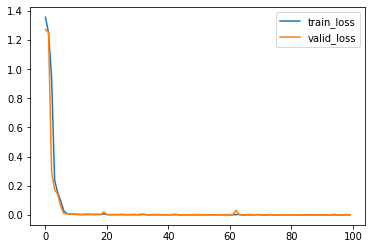

In [5]:
model = train(model,max_epochs=100)

In [6]:
y_pred = pd.DataFrame(model(X_test).detach().numpy(),columns=y_col)
y_real = pd.DataFrame(Y_test.detach().numpy(),columns=y_col)

In [11]:
from sklearn.metrics import r2_score,mean_squared_error
import numpy as np
import warnings 
warnings.filterwarnings('ignore')

def mape(y_true, y_pred, e = 2e-2):
  y_true, y_pred = np.array(y_true), np.array(y_pred)
  mask = y_true > e
  y_true, y_pred = y_true[mask], y_pred[mask]
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def show_metrics(y_real,y_pred,e=2e-2):
  res = pd.DataFrame(index=y_pred.columns,columns=['R2','MSE','MAPE'])
  for i in y_pred.columns:
      res.loc[i,'R2'] = np.clip(r2_score(y_real[i],y_pred[i]),0,1)
      res.loc[i,'MSE'] = mean_squared_error(y_real[i],y_pred[i])
      res.loc[i,'MAPE'] = mape(y_real[i],y_pred[i],e)
  res.loc['AVG'] = res.mean(axis=0)
  return res

In [12]:
zero_std_col = df[y_col].columns[(df[y_col].describe().T['std'] == 0).values]

In [13]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
show_metrics(y_real.drop(zero_std_col,axis=1),y_pred.drop(zero_std_col,axis=1))

,R2,MSE,MAPE
Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Methane_wt%,0.997858,3.93143e-05,0.226945
Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Ethane_wt%,0.999615,0.00168146,0.0763949
Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Propane_wt%,0.998325,0.000682833,0.057951
Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Butane_wt%,0.999561,0.000626205,0.213931
Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Pentane_wt%,0.998531,0.00131942,0.821551
Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Hexane_wt%,0.973734,5.50481e-05,3.01352
Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Benzene_wt%,0.997479,0.00286774,0.528027
Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Cyclohexane_wt%,0.45419,1.64654e-06,NaN
Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Heptane_wt%,0,5.05326e-07,NaN
Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Methylcyclohexane_wt%,0,1.99212e-07,NaN
